In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
#pip install -U statsmodels
import statsmodels.api as sm 

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#  Preprocesamiento de Datos

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y reorganizo en un solo dataset de la siguiente manera : [GitHub | properati_argentina](https://github.com/BraianVicente/properati_argentina/blob/master/src/TP1%20-%20Properati%20-%20Parseo%20de%20datos%20por%20fecha.ipynb)

In [3]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

Transformando el formato del feature created_on para manejarlo como fecha

Completamos la columna 'state_name'

In [4]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

Filtramos unicamente los que nos interesan que corresponde a capital federal y alrededores

In [5]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [6]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [7]:
sell_properati.drop(inplace=True,\
    labels=['country_name','description','extra','id', u'image_thumbnail','operation'\
            ,'place_with_parent_names_l1','place_with_parent_names_l2', 'properati_url','surface_in_m2','title',\
           ],axis=1)

Podemos seguir trabajando con los datos que no cuentan con la informacion de Zona utilizando la ubicacion para identificarlos segun el barrio al que pertenecen pero en esta ocacion decidimos dejarlos de lado pues no son una cantidad significativa de datos

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [8]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [9]:
sell_properati = sell_properati[sell_properati['zone'] != '']

In [10]:
#Calcula el precio la incognita (incognita = divisor/dividendo) para todo divisor mayor a cero y todo dividendo mayor a cero.

def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

# Continuaremos trabajando con el set de datos completo para disponer de toda la informacion.

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [11]:
sell_properati_filter = sell_properati

In [12]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [13]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [14]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [15]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [16]:
sell_properati_filter = sell_properati_filter[~((sell_properati_filter['surface_total_in_m2'] == 0 ) | \
                     (sell_properati_filter['price'] == 0 ))]

In [17]:
sell_properati_filter[['surface_total_in_m2','price_usd_per_m2','price_per_m2']].mean()

surface_total_in_m2    7402.093163
price_usd_per_m2       2268.710530
price_per_m2           3892.322905
dtype: float64

In [18]:
sell_properati_filter[(pd.notnull(sell_properati_filter['surface_total_in_m2']))]\
            [['surface_total_in_m2','price_usd_per_m2','price_per_m2','price_aprox_usd','price']].shape

(278094, 5)

Filtraremos los datos que tengan una superficie total en metros cuadrados entre 0 y 1000

In [19]:
filter_properati = sell_properati_filter[(sell_properati_filter['price_aprox_usd'] < 600000) &\
                                         (sell_properati_filter['price_usd_per_m2'] < 5000) & \
                                         (sell_properati_filter['surface_total_in_m2'] < 1000)]

In [20]:
float(filter_properati.shape[0]) / float(sell_properati.shape[0]) * 100

62.02927539329903

In [21]:
filter_properati.columns

Index([u'created_on', u'currency', u'expenses', u'floor', u'geonames_id',
       u'lat', u'lat-lon', u'lon', u'place_name', u'place_with_parent_names',
       u'price', u'price_aprox_local_currency', u'price_aprox_usd',
       u'price_per_m2', u'price_usd_per_m2', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_total_in_m2',
       u'zone'],
      dtype='object')

In [22]:
pd.DataFrame(data=sell_properati.state_name.unique(),columns=['states'])

,states
0,Bs.As. G.B.A. Zona Sur
1,Capital Federal
2,Bs.As. G.B.A. Zona Oeste
3,Bs.As. G.B.A. Zona Norte


In [23]:
df = pd.DataFrame(data=sell_properati.place_name.unique(),columns=['place_name']).reset_index()


In [24]:
df.rename(columns={'index':'id_place_name'},inplace=True)

In [25]:
filter_properati = filter_properati.merge(how='left',left_on='place_name',right_on='place_name',right=df)

In [26]:
df = pd.DataFrame(data=sell_properati.state_name.unique(),columns=['states']).reset_index()
df.rename(columns={'index':'id_states'},inplace=True)

In [27]:
filter_properati = filter_properati.merge(how='left',left_on='state_name',right_on='states',right=df)

In [28]:
df = pd.DataFrame(data=sell_properati.property_type.unique(),columns=['property_type']).reset_index()
df.rename(columns={'index':'id_property_type'},inplace=True)

In [29]:
filter_properati = filter_properati.merge(how='left',left_on='property_type',right_on='property_type',right=df)

In [30]:
filter_properati.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243749 entries, 0 to 243748
Data columns (total 25 columns):
created_on                    243749 non-null object
currency                      243749 non-null object
expenses                      19623 non-null object
floor                         47217 non-null float64
geonames_id                   199847 non-null float64
lat                           192128 non-null float64
lat-lon                       192128 non-null object
lon                           192123 non-null float64
place_name                    243749 non-null object
place_with_parent_names       243749 non-null object
price                         243749 non-null float64
price_aprox_local_currency    243749 non-null float64
price_aprox_usd               243749 non-null float64
price_per_m2                  243749 non-null float64
price_usd_per_m2              243749 non-null float64
property_type                 243749 non-null object
rooms                         1604

In [31]:
filter_properati.columns

Index([u'created_on', u'currency', u'expenses', u'floor', u'geonames_id',
       u'lat', u'lat-lon', u'lon', u'place_name', u'place_with_parent_names',
       u'price', u'price_aprox_local_currency', u'price_aprox_usd',
       u'price_per_m2', u'price_usd_per_m2', u'property_type', u'rooms',
       u'state_name', u'surface_covered_in_m2', u'surface_total_in_m2',
       u'zone', u'id_place_name', u'id_states', u'states',
       u'id_property_type'],
      dtype='object')

In [32]:
data = filter_properati.drop(axis=1,labels=['created_on','currency','lat','lat-lon','lon','place_name','place_with_parent_names','price'\
                                            ,'price_aprox_local_currency','price_per_m2','price_usd_per_m2','property_type','state_name'\
                                            ,'surface_covered_in_m2','zone','states'])

In [33]:
import re

def devolverInt(x):
    return float(re.search(r'\d+', x).group())

In [34]:
data['geonames_id'] = data.geonames_id.apply(lambda x : 0 if pd.isnull(x) else x )

In [35]:
data['expenses'] = data.expenses.apply(lambda x : devolverInt(x) if pd.notnull(x) else 0 )

In [36]:
data['floor'] = data.floor.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [37]:
data['price_aprox_usd'] = data.price_aprox_usd.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [38]:
data['rooms'] = data.rooms.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [39]:
data['surface_total_in_m2'] = data.surface_total_in_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243749 entries, 0 to 243748
Data columns (total 9 columns):
expenses               243749 non-null float64
floor                  243749 non-null float64
geonames_id            243749 non-null float64
price_aprox_usd        243749 non-null float64
rooms                  243749 non-null float64
surface_total_in_m2    243749 non-null float64
id_place_name          243749 non-null int64
id_states              243749 non-null int64
id_property_type       243749 non-null int64
dtypes: float64(6), int64(3)
memory usage: 18.6 MB


In [41]:
data.tail()

,expenses,floor,geonames_id,price_aprox_usd,rooms,surface_total_in_m2,id_place_name,id_states,id_property_type
243744,0.0,0.0,3427753.0,130000.0,1.0,49.0,15,3,1
243745,0.0,0.0,3427753.0,160000.0,4.0,203.0,15,3,0
243746,0.0,0.0,3430550.0,65000.0,2.0,120.0,61,2,0
243747,8600.0,0.0,3436109.0,550000.0,3.0,324.0,31,1,1
243748,0.0,1.0,3429979.0,450000.0,3.0,268.0,22,3,0


En la etapa de preprocesamiento de datos se opto por utilizar la mayor cantida de columnas posibles, con modificaciones, identificando cada place_name y state_name y tipo de propiedad con un numero para poder utilizarlo. Ademas se completo con 0 los datos que datos nulos. 

# Normalizacion de datos

In [42]:
train = data.head(int(float(data.shape[0]) * 0.8)).copy()

In [43]:
train_target = train[['price_aprox_usd']].copy()

In [44]:
train.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [45]:
test = data.tail(int(float(data.shape[0]) * 0.2)).copy()

In [46]:
test_target = test[['price_aprox_usd']].copy()

In [47]:
test.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [48]:
for col in train.columns :
    col_mean = train[col].mean()
    col_std = train[col].std()
    train[col] = (train[col] - col_mean) / col_std

In [49]:
for col in test.columns :
    col_mean = test[col].mean()
    col_std = test[col].std()
    test[col] = (test[col] - col_mean) / col_std

# Reduccion de Dimensiones

In [50]:
from sklearn import decomposition

In [51]:
svd = decomposition.TruncatedSVD(n_components=train.shape[1]-1)

In [52]:
train_transform = svd.fit_transform(train)

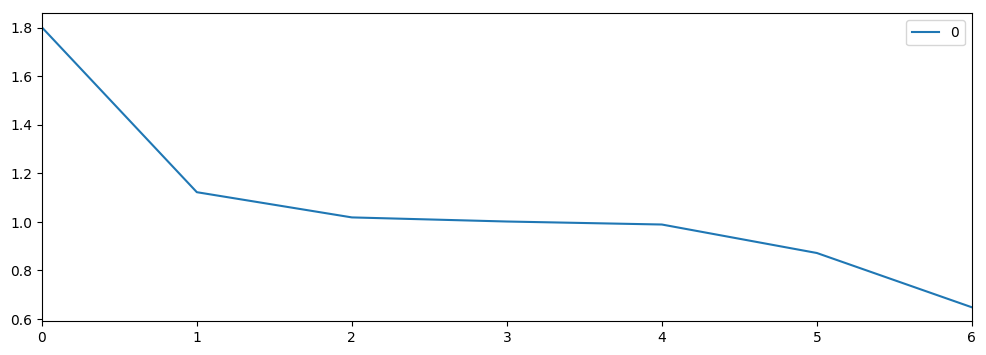

In [53]:
pd.DataFrame(svd.explained_variance_).plot()

Con nuestro grafico se puede estimar que con 2 columnas unicamente, se puede representar correctamente nuestro set de datos.

In [54]:
test_transform = svd.transform(test)

In [55]:
test = pd.DataFrame(test_transform)

In [56]:
train = pd.DataFrame(train_transform)

# Machine Learning


En esta etapa de machine learning se va a usar KNN con distancia euclidea, y vamos a calcular el MSE de nuestro set de entrenamiento. La idea es utilizando grid search, encontrar los mejores valores de K para nuestro set de datos. La distancia usada es la euclidea, ya que es la que mejor resultados obtiene.

Nuestro set de entrenamiento se encuentra normalizado y ademas se le aplico SVD para descomponer en las columnas mas significativas. En esta opcion no se opto por reducir la cantidad de dimensiones ya que no aporta ninguna mejora. 

In [57]:
from sklearn import tree

In [58]:
msqDF = pd.DataFrame(columns={'max_depth','min_sample_split','min_samples_leaf','mean_squear_error'})

In [64]:
for max_d in xrange(1,1000) :
    print max_d
    for min_s_p in xrange(2,3):
        for min_s_l in xrange(1,2):
            decision_tree = tree.DecisionTreeRegressor(max_depth=max_d, min_samples_split=min_s_p,\
                                                                min_samples_leaf=min_s_l, max_features=None,\
                                                                random_state=5, max_leaf_nodes=None)
            decision_tree.fit(train,train_target)
            test_prediction = decision_tree.predict(test)
            msq_decision_tree = mean_squared_error(test_prediction, test_target)
            msqDF = msqDF.append( pd.DataFrame(data={'max_depth' : [max_d],'min_sample_split' : [min_s_p] ,'min_samples_leaf': [min_s_l],\
                                                     'mean_squear_error' :[msq_decision_tree]}) )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [65]:
msqDF

,max_depth,mean_squear_error,min_sample_split,min_samples_leaf
0,1,1.107841e+10,2,1
0,2,9.514122e+09,2,1
0,3,8.745803e+09,2,1
0,4,8.303824e+09,2,1
0,5,8.182522e+09,2,1
0,6,8.770198e+09,2,1
0,7,8.904574e+09,2,1
0,8,9.060154e+09,2,1
0,9,9.651843e+09,2,1
0,10,1.036457e+10,2,1


In [66]:
msqDF[msqDF['mean_squear_error'] == msqDF.mean_squear_error.min()]

,max_depth,mean_squear_error,min_sample_split,min_samples_leaf
0,5,8.182522e+09,2,1


In [67]:
msqDF.min_sample_split = msqDF.min_sample_split.astype(int)

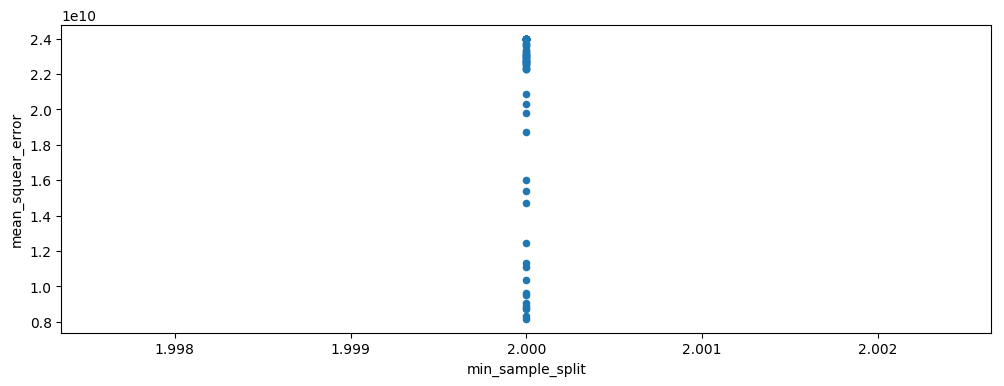

In [68]:
msqDF[['min_sample_split','mean_squear_error']].plot.scatter(x='min_sample_split',y='mean_squear_error')

In [69]:
msqDF.max_depth = msqDF.max_depth.astype(int)

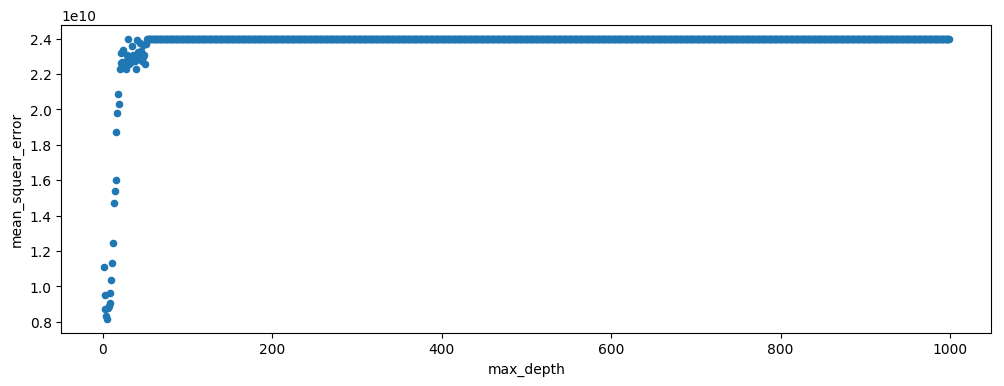

In [70]:
msqDF[['max_depth','mean_squear_error']].plot.scatter(x='max_depth',y='mean_squear_error')

In [71]:
msqDF.min_samples_leaf = msqDF.min_samples_leaf.astype(int)

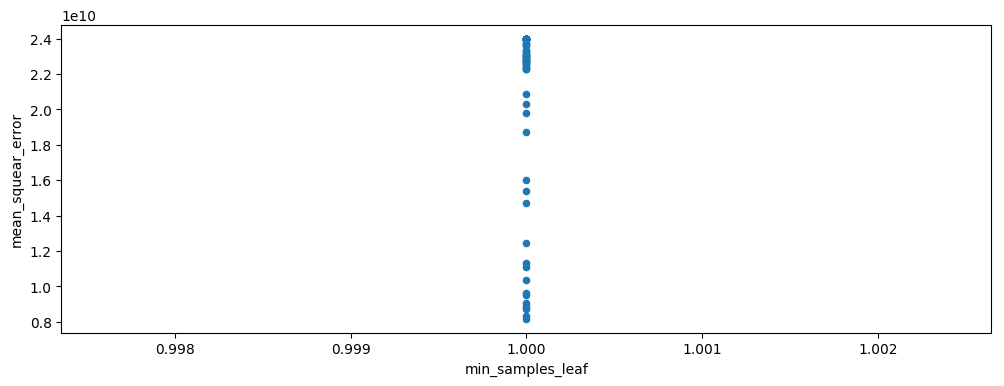

In [72]:
msqDF[['min_samples_leaf','mean_squear_error']].plot.scatter(x='min_samples_leaf',y='mean_squear_error')

In [74]:
for min_s_p in xrange(2,100):
    print min_s_p
    for min_s_l in xrange(2,100):
        decision_tree = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=min_s_p,\
                                                            min_samples_leaf=min_s_l, max_features=None,\
                                                            random_state=5, max_leaf_nodes=None)
        decision_tree.fit(train,train_target)
        test_prediction = decision_tree.predict(test)
        msq_decision_tree = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'max_depth' : [5],'min_sample_split' : [min_s_p] ,'min_samples_leaf': [min_s_l],\
                                                 'mean_squear_error' :[msq_decision_tree]}) )

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [75]:
msqDF[msqDF['mean_squear_error'] == msqDF.mean_squear_error.min()]

,max_depth,mean_squear_error,min_sample_split,min_samples_leaf
0,5,8.177912e+09,2,98
0,5,8.177912e+09,2,99
0,5,8.177912e+09,3,98
0,5,8.177912e+09,3,99
0,5,8.177912e+09,4,98
0,5,8.177912e+09,4,99
0,5,8.177912e+09,5,98
0,5,8.177912e+09,5,99
0,5,8.177912e+09,6,98
0,5,8.177912e+09,6,99


In [76]:
msqDF.min_sample_split = msqDF.min_sample_split.astype(int)

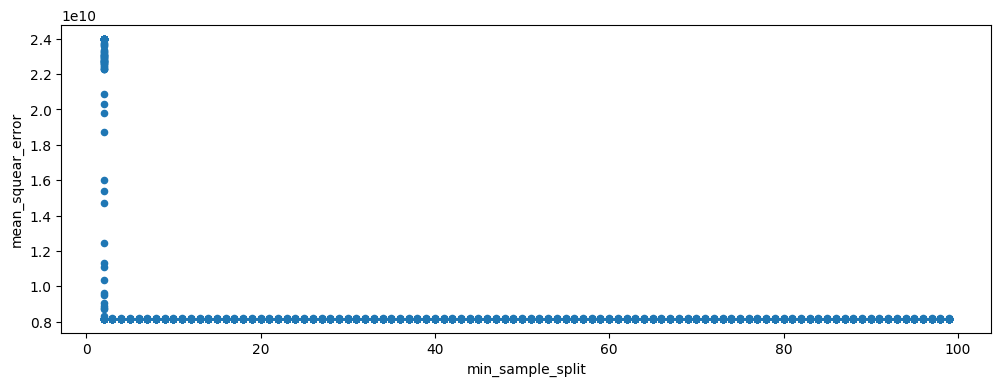

In [77]:
msqDF[['min_sample_split','mean_squear_error']].plot.scatter(x='min_sample_split',y='mean_squear_error')

In [78]:
msqDF.max_depth = msqDF.max_depth.astype(int)

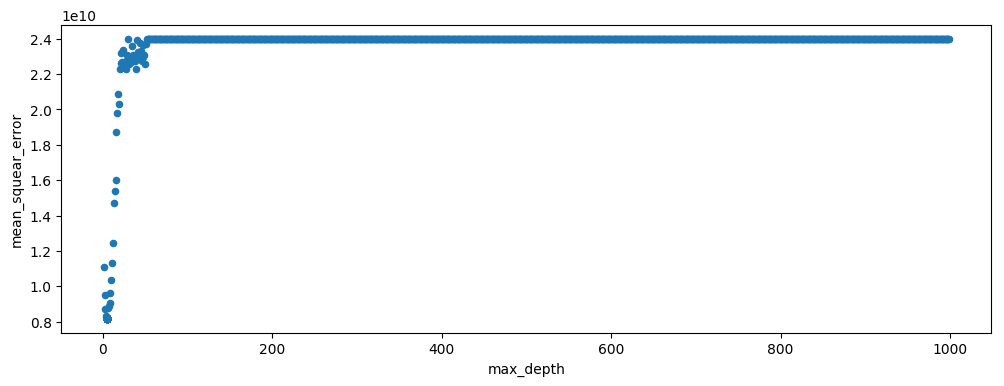

In [79]:
msqDF[['max_depth','mean_squear_error']].plot.scatter(x='max_depth',y='mean_squear_error')

In [80]:
msqDF.min_samples_leaf = msqDF.min_samples_leaf.astype(int)

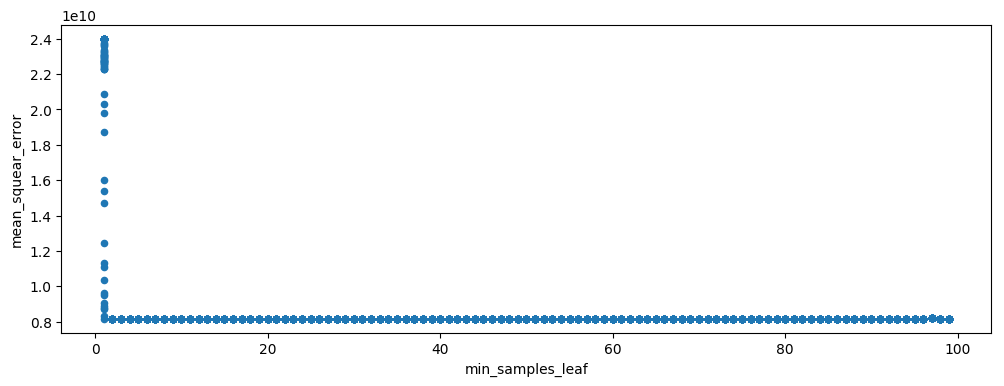

In [81]:
msqDF[['min_samples_leaf','mean_squear_error']].plot.scatter(x='min_samples_leaf',y='mean_squear_error')

msqDF.min_sample_split = msqDF.min_sample_split.astype(int)

msqDF[['min_sample_split','mean_squear_error']].plot.scatter(x='min_sample_split',y='mean_squear_error')

msqDF.max_depth = msqDF.max_depth.astype(int)

msqDF[['max_depth','mean_squear_error']].plot.scatter(x='max_depth',y='mean_squear_error')

msqDF.min_samples_leaf = msqDF.min_samples_leaf.astype(int)

msqDF[['min_samples_leaf','mean_squear_error']].plot.scatter(x='min_samples_leaf',y='mean_squear_error')

msqDF[msqDF['mean_squear_error'] == msqDF.mean_squear_error.min()]

msqDF.describe()

msqDF

msqDF.k_Neighbors = msqDF.k_Neighbors.astype(float)

msqDF.mean_squear_error = msqDF.mean_squear_error.astype(float)

msqDF.plot.scatter(x=['c','gamma'],y='mean_squear_error')

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(200)

###  Se llega la conclusion de que con un nuestro set de datos los valores optimos de k oscilan entre los 250 y 400 aproximadamente. 

for k in xrange(1,1+2000) :
    print k
    for p in xrange(2,1+2):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,n_jobs=-1,p=p)
        knn.fit(train,train_target)
        test_prediction = knn.predict(test)
        msq_knn = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'k-Neighbors' : [k],'p_minkowski' : [p] ,'mean_squear_error' :[msq_knn]}) )

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(20)

knn = neighbors.KNeighborsRegressor(n_neighbors=2000,n_jobs=-1,p=2)
knn.fit(train,train_target)
test_prediction = knn.predict(test)
msq_knn = mean_squared_error(test_prediction, test_target)
msqDF = msqDF.append( pd.DataFrame(data={'k-Neighbors' : [2000],'p_minkowski' : [2] ,'mean_squear_error' :[msq_knn]}) )

msqDF[msqDF.p_minkowski == 2 ].sort_index(by='mean_squear_error',ascending=True).head(20)

msqDF.rename(columns={'k-Neighbors':'k_Neighbors'},inplace=True)

msqDF.k_Neighbors = msqDF.k_Neighbors.astype(int)

msqDF.plot.scatter(x='k_Neighbors',y='mean_squear_error')

for k in xrange(200,201+1800) :
    print k
    for p in xrange(2,1+3):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,n_jobs=-1,p=p)
        knn.fit(train,train_target)
        test_prediction = knn.predict(test)
        msq_knn = mean_squared_error(test_prediction, test_target)
        msqDF = msqDF.append( pd.DataFrame(data={'k_Neighbors' : [k],'p_minkowski' : [p] ,'mean_squear_error' :[msq_knn]}) )

msqDF.plot.scatter(x='k_Neighbors',y='mean_squear_error')